# Customer Segmentation as the Base for Campaign Planning of a Retail Store (Case Study)

*Capstone Project by Akhir Syabani*

*Outline of the notebook:*
- INTRODUCTION
- DATA
- METHODOLOGY
- Part 1a: CUSTOMER SEGMENTATION ANALYSIS
- Part 1b: CUSTOMER SEGMENTATION RESULTS
- Part 2a: CUSTOMER RESPONSE PREDICTION MODELING
- Part 2b: CUSTOMER RESPONSE MODELING RESULT - SUMMARY
- CONCLUSION AND RECOMMENDATIONS

## INTRODUCTION

Customer segmentation is a vital part of retail industry as it helps companies to create and deploy the right strategies. Companies can build a better customer experience or developing attractive sales promotions that will boost their revenues in return.

In this case study, I explored a sample of Customer Segmentation that would help a retail store to plan and budget for their next campaigns. There are two main parts of this project:

**First,** I created a customer segmentation based on customers' profile from internal membership data of a retail store, including transaction habits. The goal is to help the management on the decision making, which to produce a valuable input as an additional consideration before they move forward to develop the right strategies according to their available budget.

**Second,** I built a model to predict customers' likelihood to response to a campaign based on their previous response toward a campaign or a promotion.

## DATA

- For customer segmentation, the data is from [here](https://www.kaggle.com/regivm/retailtransactiondata?select=Retail_Data_Transactions.csv). Ideally, the data need to include customers' static data (or demographic) and transaction habits. However, the demographic data is currently unavailable. Within the available data, I used the transaction records of customers which included transaction dates and each of the transaction amount. I counted the data to determine the transaction frequency of each customer, and the average amount of each purchase accordingly. The period is from May 2011 to March 2015. For simplicity, I refer the data as **Customer Transactions** data. The data consist of around 125,000 transactions from 6889 unique customers.

- For the second part, I added the data from [here](https://www.kaggle.com/regivm/retailtransactiondata?select=Retail_Data_Response.csv), which contained customers' response toward a previous campaign (whether they previously responded or ignored the campaign), we can call it as **Customer Responses**. The available responses were collected from 6884 of 6889 unique customers.

## METHODOLOGY

- I clustered the **Customer Transactions** data using K-Means clustering. To determine the optimum K, I used the elbow method.
- For the second part, I built the prediction model using Logistic Regression, as the target data that is categorical variable (whether customer will likely to respon to a campaign or not, from additional related sample data of **Customer Responses**.

## Part 1a: CUSTOMER SEGMENTATION ANALYSIS

In [1]:
# import the pandas and zipfile to load the csv file
import pandas as pd
import zipfile

In [2]:
# load the csv file
zf = zipfile.ZipFile(r"\Users\ASUS\Downloads\10664_14912_bundle_archive.zip")
Raw_Trx = pd.read_csv(zf.open("Retail_Data_Transactions.csv"))
Raw_Trx

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78
...,...,...,...
124995,CS8433,26-Jun-11,64
124996,CS7232,19-Aug-14,38
124997,CS8731,28-Nov-14,42
124998,CS8133,14-Dec-13,13


In [3]:
# determine the frequency of transactions
Raw_Trx2=Raw_Trx.groupby(['customer_id']).count().reset_index()
Raw_Trx2.head()

,customer_id,trans_date,tran_amount
0,CS1112,15,15
1,CS1113,20,20
2,CS1114,19,19
3,CS1115,22,22
4,CS1116,13,13


In [4]:
# add the frequency label, remove transaction date as it is not used for the segmentation
Raw_Trx2.drop(['trans_date'],axis=1, inplace=True)
Raw_Trx2.rename(columns={'tran_amount': 'frequency'}, inplace=True)
Raw_Trx2.head()

,customer_id,frequency
0,CS1112,15
1,CS1113,20
2,CS1114,19
3,CS1115,22
4,CS1116,13


In [5]:
# find the average transaction amount
Raw_Trx3=Raw_Trx.groupby(['customer_id']).mean().reset_index()
Raw_Trx3.head()

,customer_id,tran_amount
0,CS1112,67.466667
1,CS1113,74.500000
2,CS1114,75.368421
3,CS1115,75.409091
4,CS1116,65.923077


In [6]:
# create the label 'avg_amt' for the average amount of each purchase.
Raw_Trx3.rename(columns={'tran_amount': 'avg_amt'}, inplace=True)
Raw_Trx3.head()

,customer_id,avg_amt
0,CS1112,67.466667
1,CS1113,74.500000
2,CS1114,75.368421
3,CS1115,75.409091
4,CS1116,65.923077


In [7]:
# merge the frequency and average amount for each customer
trx_merged=pd.merge(Raw_Trx2,Raw_Trx3,on='customer_id')
trx_merged.head()

,customer_id,frequency,avg_amt
0,CS1112,15,67.466667
1,CS1113,20,74.500000
2,CS1114,19,75.368421
3,CS1115,22,75.409091
4,CS1116,13,65.923077


In [8]:
# we can see there are 6889 unique customers based on their Customer IDs.
trx_merged.shape

(6889, 3)

In [9]:
# drop 'customer_id' which contains string values, replace with 'new_id' that only contains its integers.
# this is done to prevent errors.
trx_merged2=trx_merged.drop(['customer_id'],axis=1)
trx_merged2['new_id']=trx_merged2.index+1112 	
trx_merged2.head()

,frequency,avg_amt,new_id
0,15,67.466667,1112
1,20,74.500000,1113
2,19,75.368421,1114
3,22,75.409091,1115
4,13,65.923077,1116


In [10]:
# move 'new_id' as the first column
trx_merged3= trx_merged2.set_index('new_id')
trx_merged3.head()

,frequency,avg_amt
new_id,,
1112,15,67.466667
1113,20,74.500000
1114,19,75.368421
1115,22,75.409091
1116,13,65.923077


In [11]:
# reset the index
trx_merged4=trx_merged3.reset_index()
trx_merged4.head()

,new_id,frequency,avg_amt
0,1112,15,67.466667
1,1113,20,74.500000
2,1114,19,75.368421
3,1115,22,75.409091
4,1116,13,65.923077


In [12]:
# import the required modules for further analysis
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans
from sklearn import datasets
iris = datasets.load_iris()

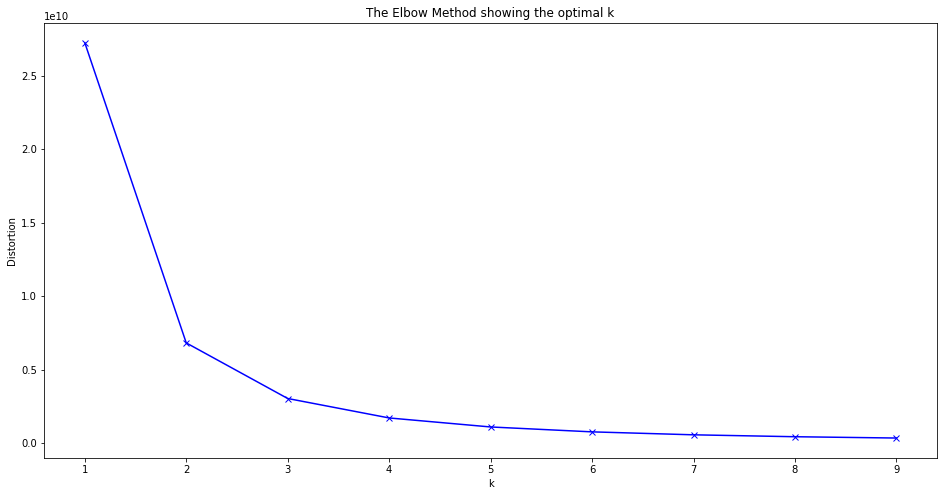

In [13]:
# elbow method to determine the optimum K for K-Means clustering.
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(trx_merged4)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We can see that the optimum K is 3.

In [14]:
# normalize the data before processing for K-Means
from sklearn.preprocessing import StandardScaler

X = trx_merged4.values[:,1:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[-0.60563997,  0.35250273],
       [ 0.35726189,  0.91853224],
       [ 0.16468152,  0.98842115],
       ...,
       [-0.99080071, -1.21413819],
       [-1.18338108, -2.50849478],
       [-0.99080071, -1.7774851 ]])

In [15]:
# K-Means clustering with 3 clusters
num_clusters = 3

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

In [16]:
# add the 'Cluster Labels'
trx_merged4["Cluster Labels"]=labels
trx_merged4

,new_id,frequency,avg_amt,Cluster Labels
0,1112,15,67.466667,2
1,1113,20,74.500000,2
2,1114,19,75.368421,2
3,1115,22,75.409091,0
4,1116,13,65.923077,2
...,...,...,...,...
6884,7996,13,44.769231,1
6885,7997,14,38.785714,1
6886,7998,13,48.000000,1
6887,7999,12,31.916667,1


Further, we can examine each cluster by grouping the data and visualize the clusters, as shown below.

In [17]:
trx_merged4.groupby('Cluster Labels').count()

,new_id,frequency,avg_amt
Cluster Labels,,,
0,2215,2215,2215
1,1895,1895,1895
2,2779,2779,2779


In [18]:
trx_merged4.groupby('Cluster Labels').mean()

,new_id,frequency,avg_amt
Cluster Labels,,,
0,3617.122348,23.992325,70.105727
1,7014.614248,13.150923,44.714401
2,3627.802807,16.889529,70.019915


In [19]:
trx_merged4.groupby('Cluster Labels').min()

,new_id,frequency,avg_amt
Cluster Labels,,,
0,1115,21,44.038462
1,1487,4,26.700000
2,1112,6,54.157895


In [20]:
trx_merged4.groupby('Cluster Labels').max()

,new_id,frequency,avg_amt
Cluster Labels,,,
0,7682,39,83.954545
1,8000,25,62.571429
2,7821,20,87.400000


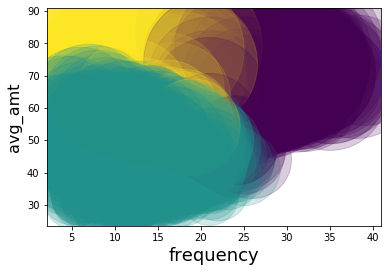

In [68]:
area = np.pi * ( X[:, 1])**2  
plt.scatter(X[:, 0], X[:, 1], s=area, c=labels.astype(np.float), alpha=0.2)
plt.xlabel('frequency', fontsize=18)
plt.ylabel('avg_amt', fontsize=16)

plt.show()

## Part 1b: CUSTOMER SEGMENTATION RESULTS

We now have three customer segments based on the clustering:

**Cluster 1: Highest Frequency with Big Ticket Sizes or "The Most Loyal Customers"**

This cluster has 2215 members, or 32% of total customers. The average frequency of their purchases is around 24 times, with the average amount of around 70 dollars each.

**Cluster 2: Lowest Frequency with Small Ticket Sizes or "The Average Customers"**

This cluster has 1895 members, or 28% of total customers. The average frequency of their purchases is around 13 times, with the average amount of around 44 dollars each.

**Cluster 3: Mid-Range Frequency with Big Ticket Sizes or "The Potential Upgrade"**

This cluster has 2779 members, or 40% of total customers, which makes them the biggest group of the three clusters. The average frequency of their purchases is around 17 times, with the average amount of around 70 dollars each.

## Part 2a: CUSTOMER RESPONSE PREDICTION MODELING

In [21]:
# load the additional file of customer responses from previous campaign
zf = zipfile.ZipFile(r"\Users\ASUS\Downloads\10664_14912_bundle_archive.zip")
responses = pd.read_csv(zf.open("Retail_Data_Response.csv"))
responses

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1
...,...,...
6879,CS8996,0
6880,CS8997,0
6881,CS8998,0
6882,CS8999,0


We can see that there are only 6884 customer responses from 6889 overall unique customers. Hence we will only use 6884 customer IDs for this modeling. Response=0 means that they previously didn't respond to a campaign offered at them. Response=1 means they responded to the campaign.

In [22]:
# replace 'customer_id' with 'new_id' for merging purpose and to prevent errors.
responses2=responses.drop(['customer_id'],axis=1)
responses2['new_id']=responses2.index+1112
responses2.head()

,response,new_id
0,0,1112
1,0,1113
2,1,1114
3,1,1115
4,1,1116


In [23]:
responses3=responses2.set_index('new_id')
responses3.head()

,response
new_id,
1112,0
1113,0
1114,1
1115,1
1116,1


In [24]:
responses4=responses3.reset_index()
responses4.head()

,new_id,response
0,1112,0
1,1113,0
2,1114,1
3,1115,1
4,1116,1


In [41]:
# merge the responses with customer transactions data and cluster labels.
customers=pd.merge(trx_merged4,responses4,on='new_id',copy=False)
customers

,new_id,frequency,avg_amt,Cluster Labels,response
0,1112,15,67.466667,2,0
1,1113,20,74.500000,2,0
2,1114,19,75.368421,2,1
3,1115,22,75.409091,0,1
4,1116,13,65.923077,2,1
...,...,...,...,...,...
6879,7991,14,43.000000,1,0
6880,7992,9,30.777778,1,0
6881,7993,10,40.900000,1,0
6882,7994,16,46.812500,1,0


In [42]:
cdf=customers[['frequency','avg_amt','Cluster Labels','response']]
cdf.head()

,frequency,avg_amt,Cluster Labels,response
0,15,67.466667,2,0
1,20,74.500000,2,0
2,19,75.368421,2,1
3,22,75.409091,0,1
4,13,65.923077,2,1


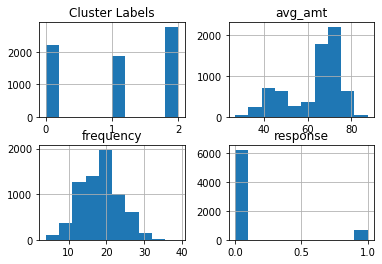

In [43]:
# visualize each variable.
viz = customers[['frequency','avg_amt','Cluster Labels','response']]
viz.hist()
plt.show()

In [44]:
customers.groupby(['response']).count()

,new_id,frequency,avg_amt,Cluster Labels
response,,,,
0,6237,6237,6237,6237
1,647,647,647,647


In [45]:
customers.groupby(['response', 'Cluster Labels']).size()

response  Cluster Labels
0         0                 1847
          1                 1841
          2                 2549
1         0                  368
          1                   49
          2                  230
dtype: int64

In [46]:
customers.groupby(['Cluster Labels','response']).size()

Cluster Labels  response
0               0           1847
                1            368
1               0           1841
                1             49
2               0           2549
                1            230
dtype: int64

In [47]:
customers.describe()

,new_id,frequency,avg_amt,Cluster Labels,response
count,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000
mean,4553.500000,18.148605,63.102679,1.081929,0.093986
std,1987.383959,5.193020,12.415861,0.847846,0.291831
min,1112.000000,4.000000,26.700000,0.000000,0.000000
25%,2832.750000,14.000000,52.741071,0.000000,0.000000
50%,4553.500000,18.000000,67.708333,1.000000,0.000000
75%,6274.250000,22.000000,72.009615,2.000000,0.000000
max,7995.000000,39.000000,87.400000,2.000000,1.000000


In [48]:
Xc=np.asarray(customers[['new_id','frequency','avg_amt','Cluster Labels']])
Xc[0:5]

array([[1112.        ,   15.        ,   67.46666667,    2.        ],
       [1113.        ,   20.        ,   74.5       ,    2.        ],
       [1114.        ,   19.        ,   75.36842105,    2.        ],
       [1115.        ,   22.        ,   75.40909091,    0.        ],
       [1116.        ,   13.        ,   65.92307692,    2.        ]])

In [49]:
Xc.shape

(6884, 4)

In [50]:
yc=np.asarray(customers['response'])
yc[0:5]

array([0, 0, 1, 1, 1], dtype=int64)

In [51]:
yc.shape

(6884,)

In [52]:
from sklearn import preprocessing
Xc = preprocessing.StandardScaler().fit(Xc).transform(Xc)
Xc[0:5]

array([[-1.73179922, -0.606359  ,  0.35151038,  1.08290643],
       [-1.73129601,  0.35654189,  0.91803123,  1.08290643],
       [-1.7307928 ,  0.16396171,  0.9879808 ,  1.08290643],
       [-1.73028959,  0.74170225,  0.99125667, -1.27618466],
       [-1.72978638, -0.99151936,  0.22717734,  1.08290643]])

**Train/Test**

In [53]:
from sklearn.model_selection import train_test_split
Xc_train, Xc_test, yc_train, yc_test = train_test_split( Xc, yc, test_size=0.2, random_state=4)
print ('Train set:', Xc_train.shape,  yc_train.shape)
print ('Test set:', Xc_test.shape,  yc_test.shape)

Train set: (5507, 4) (5507,)
Test set: (1377, 4) (1377,)


In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(Xc_train,yc_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
yhat = LR.predict(Xc_test)
yhat

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [56]:
yhat_prob = LR.predict_proba(Xc_test)
yhat_prob

array([[0.87832583, 0.12167417],
       [0.87212398, 0.12787602],
       [0.92932232, 0.07067768],
       ...,
       [0.81057508, 0.18942492],
       [0.92837541, 0.07162459],
       [0.80682569, 0.19317431]])

**Model Evaluation Scores**

In [57]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(yc_test, yhat)

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


0.9005083514887436

In [58]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(yc_test, yhat, labels=[1,0]))

[[   0  137]
 [   0 1240]]


Confusion matrix, without normalization
[[   0  137]
 [   0 1240]]


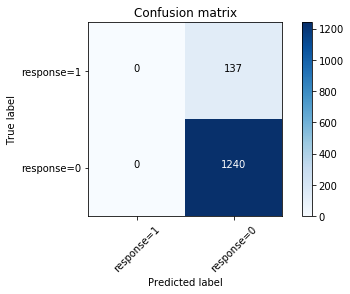

In [59]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(yc_test, yhat, labels=[1,0])
np.set_printoptions(precision=1)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['response=1','response=0'],normalize= False,  title='Confusion matrix')

In [60]:
print (classification_report(yc_test, yhat))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1240
           1       0.00      0.00      0.00       137

    accuracy                           0.90      1377
   macro avg       0.45      0.50      0.47      1377
weighted avg       0.81      0.90      0.85      1377



C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
from sklearn.metrics import log_loss
log_loss(yc_test, yhat_prob)

0.311136545304687

## Part 2b: CUSTOMER RESPONSE MODELING RESULT - SUMMARY

Customer Response Modeling Score

| Jaccard Score | f-1 score | log loss |
|---|---|---|
|0.90|0.85|0.31|

## CONCLUSION AND RECOMMENDATIONS

Based on historical transactions, we have three customer segments:

|**Segment**|**Proportion**|**Average Frequency**|**Average Purchase Amount (Dollars)**|
|---|---|---|---|
|**The Most Loyal Customers**|32%|24|70|
|**The Average Customers**|28%|13|44|
|**The Potential Upgrade**|40%|17|70|

Recommendations based on segments for campaign planning:

- The management can focus on creating campaigns for the 'The Potential Upgrade' segment as they make up for 40% (the most) of the customers. The goal of the campaign should mainly focus on increasing their purchase frequency, for example by creating special events every month to attract customers and make them return to the store more regularly.
- The other option is to focus on the 'The Average Customers' to increase their ticket size or puchase amount per visit. The management can create bundling or package promotions to attract bigger purchase amount.
- The decision will largely depend on the store/company's available budget and financial projections based on the customers segment proportions. They may focus on 'The Potential Upgrade' strategies, 'The Average Customers' strategies, or they can probably afford to generally create all the possible campaigns to increase sales.

Other recommendations for future analysis:

1. The management needs to gather additional data on customer demographic information that is currently unaivalable, so that the segmentation can be performed more thoroughly. Customer membership data updates mechanism needs to be established.
2. The customer response predicting model has quite favourable evaluation scores. However, since only 10% of the customers did respond to the previous campaign, the management needs to focus on increasing the campaign take-up rate as well.